# BMI / CS 771: Homework Assignment 1

This project will use Jupyter Notebook in combination with Python scripts, offering a convenient way for you to quickly and easily interact with the code. A notebook contains many blocks of code, each of which can be run independently. You can run a cell with ctrl+enter or shift+enter (to move to the next cell).

If there are any notes you wish to leave for the teaching team, you may leave them here.

## Setup

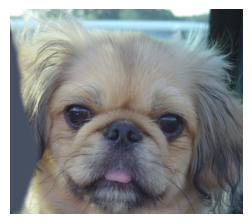

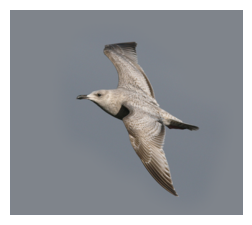

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from utils import load_image, save_image
from student_code import Compose, Scale, RandomHorizontalFlip, RandomColor, RandomRotate, RandomSizedCrop
%load_ext autoreload
%autoreload 2

image1 = load_image('../data/dog.bmp')
image2 = load_image('../data/bird.bmp')
image3 = load_image('../data/cat.bmp')
image4 = load_image('../data/plane.bmp')

# display the dog and cat images
plt.figure(figsize=(3,3)); plt.axis('off'); plt.imshow(image1);
plt.figure(figsize=(3,3)); plt.axis('off'); plt.imshow(image2);
plt.show()

## Create Image Transforms

In [2]:
# create an empty list and add transforms one by one
transforms = []
transforms.append(Scale(320))
transforms.append(RandomHorizontalFlip())
transforms.append(RandomColor(0.15))
transforms.append(RandomRotate(30))
transforms.append(RandomSizedCrop(224))
comp_transforms = Compose(transforms)
print(comp_transforms)


Scale [Shortest Side (320)]
Random Horizontal Flip
Random Color [Range 0.85 - 1.15]
Random Rotation [Range -30.00 - 30.00 Degree]
Random Crop[Size (224, 224); Area 0.25 - 1.00; Ratio 0.80 - 1.20]



## Apply Transforms to Images
All functions you need to implement in this project can be found in student_code.py. You will need to fill in the missing code pieces in the Scale, RandomRotate and RandomColor.

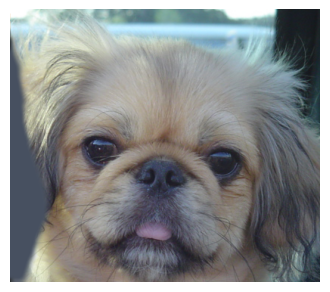

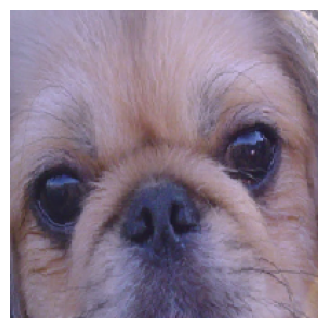

In [3]:
transformed_image1 = comp_transforms(image1)

# let's take a look at the results!
plt.figure(figsize=(4,4)); plt.axis('off'); plt.imshow(image1);
plt.figure(figsize=(4,4)); plt.axis('off'); plt.imshow(transformed_image1);

plt.show()


## Create More Results

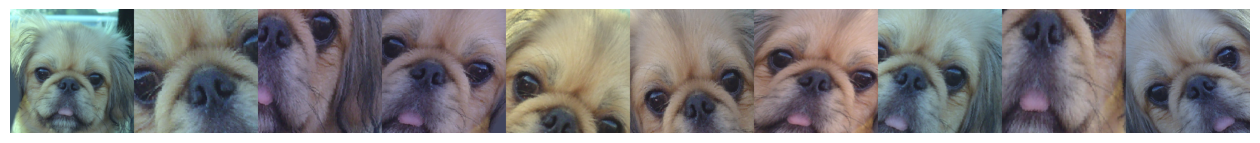

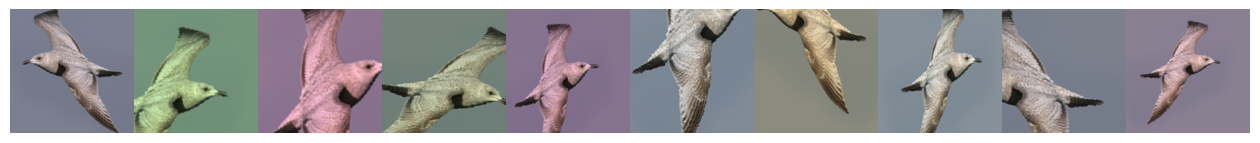

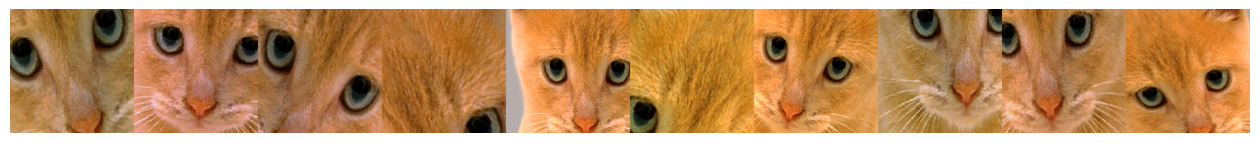

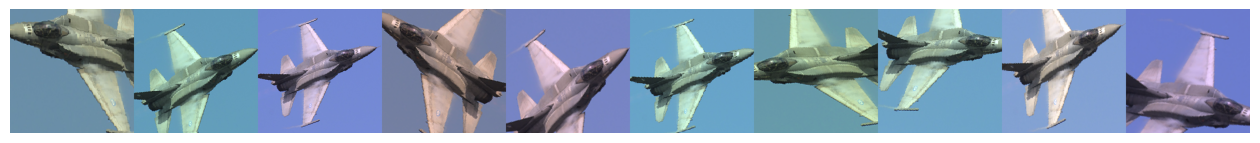

In [4]:
vis_img_list = []
for img in [image1, image2, image3, image4]:
    img_list = []
    for idx in range(10):
        img_list.append(comp_transforms(img))
    vis_img = np.concatenate(img_list, axis=1)
    vis_img_list.append(vis_img)

for vis_img in vis_img_list:
    plt.figure(figsize=(16,16)); plt.axis('off'); plt.imshow(vis_img);
    
plt.show()

## Save Results

In [5]:
for file_idx, vis_img in zip(range(len(vis_img_list)), vis_img_list):
    save_image('../results/outputs_{:d}.jpg'.format(file_idx), vis_img)

## Data Augmentation and Input Pipeline

Image transforms used for training
Scale [Shortest Side (72)]
Random Horizontal Flip
Random Crop[Size (64, 64); Area 0.64 - 1.00; Ratio 0.80 - 1.20]

Image transforms used for validation:
Scale [Shortest Side (72)]
Random Crop[Size (64, 64)]



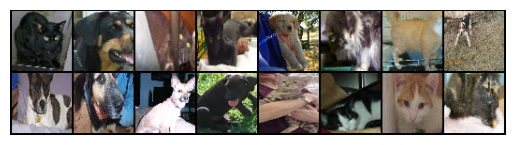

cat  	dog  	cat  	cat  	dog  	cat  	cat  	dog  
dog  	dog  	dog  	dog  	cat  	cat  	cat  	cat  



In [6]:
from student_code import ToTensor, SimpleDataset, CenterCrop, Resize, Net
import torch
import torchvision

# now we will do some real training on cats and dogs

# set up the transforms (you can play around with the combination here)
train_transforms = []
train_transforms.append(Scale(72))
train_transforms.append(RandomHorizontalFlip())
train_transforms.append(RandomSizedCrop(64, area_range=(0.64, 1.0)))
train_transforms.append(ToTensor())
train_transforms = Compose(train_transforms)

test_transforms = []
test_transforms.append(Scale(72))
test_transforms.append(CenterCrop(64))
test_transforms.append(ToTensor())
test_transforms = Compose(test_transforms)
print("Image transforms used for training")
print(train_transforms)
print("Image transforms used for validation:")
print(test_transforms)

# let us try a toy dataset
batch_size = 16
train_dataset = SimpleDataset('../data/mini_train', file_ext='jpg', transforms=train_transforms)
val_dataset = SimpleDataset('../data/mini_val', file_ext='jpg', transforms=test_transforms)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# get some random training images
dataiter = iter(train_data_loader)
images, labels = next(dataiter)

# show images
nrow = batch_size // 2
vis_img = torchvision.utils.make_grid(images, nrow=nrow).numpy()
plt.figure(); plt.axis('off'); plt.imshow(np.transpose(vis_img, (1, 2, 0)))
plt.show()
classes = ("dog", "cat")
# print labels
output = ''
for i, j in enumerate(range(batch_size), 1):
    output += f'{classes[labels[j]]:5s}' + ['\t', '\n'][i % nrow == 0]
print(output)
del dataiter


In [7]:
# network / loss function for training
device = 'cuda'
net = Net()
net = net.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

# training loop
num_epochs = 6
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 0.695
[1,   100] loss: 0.671
[1,   150] loss: 0.663
[1,   200] loss: 0.654
[1,   250] loss: 0.648
[1,   300] loss: 0.657
[1,   350] loss: 0.643
[2,    50] loss: 0.638
[2,   100] loss: 0.623
[2,   150] loss: 0.621
[2,   200] loss: 0.611
[2,   250] loss: 0.628
[2,   300] loss: 0.609
[2,   350] loss: 0.624
[3,    50] loss: 0.591
[3,   100] loss: 0.614
[3,   150] loss: 0.603
[3,   200] loss: 0.572
[3,   250] loss: 0.579
[3,   300] loss: 0.574
[3,   350] loss: 0.592
[4,    50] loss: 0.581
[4,   100] loss: 0.540
[4,   150] loss: 0.536
[4,   200] loss: 0.546
[4,   250] loss: 0.545
[4,   300] loss: 0.541
[4,   350] loss: 0.554
[5,    50] loss: 0.515
[5,   100] loss: 0.551
[5,   150] loss: 0.556
[5,   200] loss: 0.547
[5,   250] loss: 0.514
[5,   300] loss: 0.526
[5,   350] loss: 0.508
[6,    50] loss: 0.516
[6,   100] loss: 0.524
[6,   150] loss: 0.524
[6,   200] loss: 0.522
[6,   250] loss: 0.500
[6,   300] loss: 0.484
[6,   350] loss: 0.518
Finished Training


In [11]:
# performance on the validation set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in val_data_loader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the network on the validation set: {100 * correct // total} %')

Accuracy of the network on the validation set: 74 %


In [12]:
correct

741